### -------------------Predict the generation of power for the duration: October 1st, 2019 to October 27th, 2019-----------------

In [1]:
# Import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read all the data into different variables

weather_actual = pd.read_csv('E:/Work/Amaan/Jobs/reapplicationforthepostofmachinelearningengineer/weather_actuals.csv',
                            index_col=0)
power = pd.read_csv('E:/Work/Amaan/Jobs/reapplicationforthepostofmachinelearningengineer/power_actual.csv', index_col=0)
weather_forecast = pd.read_csv('E:/Work/Amaan/Jobs/reapplicationforthepostofmachinelearningengineer/weather_forecast.csv',
                              index_col=0)

In [3]:
weather_actual.head(3)

,plant_id,datetime_utc,datetime_local,cloud_cover,apparent_temperature,temperature,humidity,dew_point,wind_bearing,wind_speed,...,precip_accumulation,precip_intensity,precip_probability,precip_type,visibility,sunrise,sunset,icon,summary,updated_at
0,1,2017-09-30 18:30:00,2017-10-01 00:00:00,0.0,26.52,26,1,19.46,308,0.83,...,-9999.0,-9999.0,-9999.0,rain,3.57,2017-10-01 00:52:02,2017-10-01 12:45:07,clear-night,Clear,2019-07-16 16:37:16
1,1,2017-09-30 19:30:00,2017-10-01 01:00:00,0.0,28.78,27,1,20.06,-9999,-9999.00,...,-9999.0,-9999.0,-9999.0,rain,3.06,2017-10-01 00:52:02,2017-10-01 12:45:07,fog,Foggy,2019-07-16 16:37:16
2,1,2017-09-30 20:30:00,2017-10-01 02:00:00,0.0,26.58,26,1,19.97,-9999,-9999.00,...,-9999.0,-9999.0,-9999.0,rain,3.06,2017-10-01 00:52:02,2017-10-01 12:45:07,fog,Foggy,2019-07-16 16:37:16


In [4]:
weather_actual.shape

(13619, 30)

In [5]:
# Check for null values

weather_actual.isna().sum()

plant_id                   0
datetime_utc               0
datetime_local             0
cloud_cover                0
apparent_temperature       0
temperature                0
humidity                   0
dew_point                  0
wind_bearing               0
wind_speed                 0
wind_chill              9875
wind_gust                  0
heat_index              9875
pressure                   0
qpf                     9875
uv_index                   0
snow                    9875
pop                     9875
fctcode                 9875
ozone                      0
precip_accumulation     9875
precip_intensity           0
precip_probability         0
precip_type             7129
visibility                 0
sunrise                    0
sunset                     0
icon                       0
summary                    0
updated_at                 0
dtype: int64

#### We cannot derive much information from "plant_id", "updated_at" & "datetime_utc", hence drop these columns
#### "wind_chill", "heat_index", "qpf", "snow", "pop", "fctcode", "precip_accumulation" have around 72% missing values in weather_actual & 100% missing values in weather_forecast. Hence we need to drop them, as any imputation might create a biased model

In [6]:
weather_actual = weather_actual.drop(['plant_id','updated_at','datetime_utc','wind_chill','heat_index','qpf','snow','pop',
                                      'fctcode','precip_accumulation'], axis=1)

In [7]:
weather_actual.precip_type.value_counts()

rain     6147
-9999     343
Name: precip_type, dtype: int64

#### "precip_type" has 7129 missing values, and no entry of "no rain". Hence we'll assume that missing values are "no rain" and impute them

In [8]:
weather_actual['precip_type'] = weather_actual['precip_type'].fillna('no rain')

In [9]:
# Now confirm that there are no more missing values

weather_actual.isna().sum()

datetime_local          0
cloud_cover             0
apparent_temperature    0
temperature             0
humidity                0
dew_point               0
wind_bearing            0
wind_speed              0
wind_gust               0
pressure                0
uv_index                0
ozone                   0
precip_intensity        0
precip_probability      0
precip_type             0
visibility              0
sunrise                 0
sunset                  0
icon                    0
summary                 0
dtype: int64

#### "sunrise" & "sunset" have dates and times, out of which only time seems to be relevant information for our model. Hence we'll extract hours and minutes, and drop "sunrise" & "sunset"

In [10]:
weather_actual['sunrise'] = pd.to_datetime(weather_actual['sunrise'])
weather_actual['sunset'] = pd.to_datetime(weather_actual['sunset'])

In [11]:
weather_actual['sunrise_hour'] = weather_actual['sunrise'].dt.hour
weather_actual['sunrise_minute'] = weather_actual['sunrise'].dt.minute
weather_actual['sunset_hour'] = weather_actual['sunset'].dt.hour
weather_actual['sunset_minute'] = weather_actual['sunset'].dt.minute

In [12]:
weather_actual = weather_actual.drop(['sunrise','sunset'], axis=1)

#### There seems to be a data entry error in most of the columns of the weather_actual as "-9999", which does not seem to be a valid entry relative to the other entries of the columns
#### Hence we need to replace "-9999" with some relevant data

In [13]:
# We'll replace "-9999" with "rain" (No reason, just a judgement call)

weather_actual['precip_type'] = weather_actual['precip_type'].replace("-9999","rain")

In [14]:
weather_actual.cloud_cover.value_counts()

 0.00       6528
 1.00        556
-9999.00     428
 0.01        371
 0.03        206
            ... 
 0.77         34
 0.52         32
 0.58         31
 0.73         29
 0.47         27
Name: cloud_cover, Length: 102, dtype: int64

In [15]:
weather_actual.cloud_cover.median()

0.0

In [16]:
# We'll replace "-9999.00" with the median "0.0"

weather_actual['cloud_cover'] = weather_actual['cloud_cover'].replace(-9999.00, weather_actual['cloud_cover'].median())

In [17]:
weather_actual.wind_bearing.value_counts()

-9999    919
 270     200
 260     182
 320     181
 280     175
        ... 
 199       7
 211       7
 227       7
 175       7
 202       6
Name: wind_bearing, Length: 361, dtype: int64

In [18]:
weather_actual.wind_bearing.mean()

-498.6773625082605

In [19]:
weather_actual.wind_bearing.median()

149.0

In [26]:
weather_actual.wind_bearing.quantile([0.1,0.25,0.75,1])

0.10     14.0
0.25     79.0
0.75    293.0
1.00    359.0
Name: wind_bearing, dtype: float64

In [27]:
# We'll replace "-9999" with the median "149"

weather_actual['wind_bearing'] = weather_actual['wind_bearing'].replace(-9999, weather_actual['wind_bearing'].median())

In [28]:
weather_actual.wind_speed.value_counts()

-9999.00    740
 2.24       385
 2.68       295
 1.34       261
 3.13       209
           ... 
 6.58         1
 7.18         1
 6.51         1
 8.64         1
 6.78         1
Name: wind_speed, Length: 699, dtype: int64

In [29]:
weather_actual.wind_speed.median()

2.41

In [30]:
weather_actual.wind_speed.quantile([0.1,0.25,0.75,1])

0.10    0.61
0.25    1.62
0.75    3.33
1.00    9.73
Name: wind_speed, dtype: float64

In [31]:
# We'll replace "-9999.00" with the median "2.41"

weather_actual['wind_speed'] = weather_actual['wind_speed'].replace(-9999.00, weather_actual['wind_speed'].median())

In [32]:
weather_actual.wind_gust.value_counts()

-9999.00    3264
 3.79         37
 3.15         36
 3.29         36
 2.91         35
            ... 
 12.52         1
 8.41          1
 11.16         1
 12.98         1
 8.40          1
Name: wind_gust, Length: 1067, dtype: int64

In [33]:
weather_actual.wind_gust.median()

3.07

In [34]:
weather_actual.wind_gust.quantile([0.1,0.25,0.75,1])

0.10   -9999.000
0.25       1.185
0.75       4.710
1.00      15.150
Name: wind_gust, dtype: float64

In [35]:
# We'll replace "-9999.000" with median "3.07"

weather_actual['wind_gust'] = weather_actual['wind_gust'].replace(-9999.000, weather_actual['wind_gust'].median())

In [36]:
weather_actual.pressure.value_counts()

-9999.00    2156
 1015.32      15
 1013.41      14
 1015.37      13
 1014.74      13
            ... 
 995.74        1
 996.76        1
 1021.43       1
 996.70        1
 997.94        1
Name: pressure, Length: 2919, dtype: int64

In [38]:
weather_actual.pressure.median()

1006.9

In [39]:
weather_actual.pressure.quantile([0.1,0.25,0.75,1])

0.10   -9999.00
0.25     998.75
0.75    1014.74
1.00    1025.69
Name: pressure, dtype: float64

In [40]:
# We'll replace "-9999.00" with median "1006.9"

weather_actual['pressure'] = weather_actual['pressure'].replace(-9999.00, weather_actual['pressure'].median())

In [41]:
weather_actual.uv_index.value_counts()

 0       6141
-9999    3264
 1        710
 2        574
 5        566
 4        528
 3        440
 6        351
 7        287
 8        257
 10       175
 9        162
 11        90
 12        74
Name: uv_index, dtype: int64

In [42]:
weather_actual.uv_index.median()

0.0

In [43]:
# We'll replace "-9999" with median "0"

weather_actual['uv_index'] = weather_actual['uv_index'].replace(-9999, weather_actual['uv_index'].median())

In [44]:
weather_actual.ozone.value_counts()

-9999.00    3264
 272.10       52
 274.30       50
 277.70       48
 274.60       45
            ... 
 296.89        1
 233.60        1
 279.55        1
 294.45        1
 317.10        1
Name: ozone, Length: 1262, dtype: int64

In [45]:
weather_actual.ozone.median()

270.8

In [46]:
weather_actual.ozone.quantile([0.1,0.25,0.75,1])

0.10   -9999.0
0.25     236.9
0.75     280.8
1.00     351.7
Name: ozone, dtype: float64

In [47]:
# We'll replace "-9999.0" with median "270.8"

weather_actual['ozone'] = weather_actual['ozone'].replace(-9999.0, weather_actual['ozone'].median())

In [48]:
weather_actual.precip_intensity.value_counts()

 0.00       7574
-9999.00    3264
 0.01        604
 0.02        292
 0.03        179
            ... 
 5.45          1
 1.62          1
 2.72          1
 5.89          1
 1.47          1
Name: precip_intensity, Length: 180, dtype: int64

In [49]:
weather_actual.precip_intensity.median()

0.0

In [50]:
# We'll replace "-9999.00" by median "0.0"

weather_actual['precip_intensity'] = weather_actual['precip_intensity'].replace(-9999.00, weather_actual['precip_intensity'].median())

In [51]:
weather_actual.precip_probability.value_counts()

 0.00       7472
-9999.00    3264
 0.01        727
 0.02        414
 0.03        317
            ... 
 0.53          1
 0.46          1
 0.67          1
 0.60          1
 0.59          1
Name: precip_probability, Length: 66, dtype: int64

In [52]:
weather_actual.precip_probability.median()

0.0

In [53]:
# We'll replace "-9999.00" with median "0.0"

weather_actual['precip_probability'] = weather_actual['precip_probability'].replace(-9999.00, weather_actual['precip_probability'].median())

#### Now let us check the power table

In [54]:
power.shape

(70080, 4)

In [55]:
power.isna().sum()

datetime        0
ghi         35040
gti         35040
power           0
dtype: int64

#### drop "ghi" & "gti" as it contains 50% missing values and 50% "0", and hence we cannot extract relevant information from it

In [56]:
power = power.drop(['ghi','gti'], axis=1)

In [57]:
power.columns

Index(['datetime', 'power'], dtype='object')

In [58]:
# Rename "datetime" to "datetime_local" becasue we need to join this table with weather_actual, so both need to have a common variable

power = power.rename(columns = {'datetime':'datetime_local'})

#### We'll use inner join to merge the tables because power has datetime values for every 15 minute and weather_actual has values for every hour. By using inner join we'll get values for every hour.

In [60]:
power_actual = pd.merge(weather_actual, power, on='datetime_local', how='inner')

In [61]:
power_actual.shape

(13619, 23)

In [62]:
power_actual.head(3)

,datetime_local,cloud_cover,apparent_temperature,temperature,humidity,dew_point,wind_bearing,wind_speed,wind_gust,pressure,...,precip_probability,precip_type,visibility,icon,summary,sunrise_hour,sunrise_minute,sunset_hour,sunset_minute,power
0,2017-10-01 00:00:00,0.0,26.52,26,1,19.46,308,0.83,3.07,1007.9,...,0.0,rain,3.57,clear-night,Clear,0,52,12,45,0.0
1,2017-10-01 01:00:00,0.0,28.78,27,1,20.06,149,2.41,3.07,1006.9,...,0.0,rain,3.06,fog,Foggy,0,52,12,45,0.0
2,2017-10-01 02:00:00,0.0,26.58,26,1,19.97,149,2.41,3.07,1006.9,...,0.0,rain,3.06,fog,Foggy,0,52,12,45,0.0


#### We'll divide the numerical & categorical columns, and apply scaling and label encoding on them respectively

In [63]:
power_actual.columns

Index(['datetime_local', 'cloud_cover', 'apparent_temperature', 'temperature',
       'humidity', 'dew_point', 'wind_bearing', 'wind_speed', 'wind_gust',
       'pressure', 'uv_index', 'ozone', 'precip_intensity',
       'precip_probability', 'precip_type', 'visibility', 'icon', 'summary',
       'sunrise_hour', 'sunrise_minute', 'sunset_hour', 'sunset_minute',
       'power'],
      dtype='object')

In [64]:
numeric_columns = power_actual[['cloud_cover', 'apparent_temperature', 'temperature', 'dew_point', 'wind_bearing', 'wind_speed',
                                'wind_gust', 'pressure', 'uv_index', 'ozone', 'precip_intensity', 'precip_probability',
                                'visibility', 'sunrise_hour', 'sunrise_minute', 'sunset_hour', 'sunset_minute']]

In [65]:
numeric_columns.head(3)

,cloud_cover,apparent_temperature,temperature,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,precip_intensity,precip_probability,visibility,sunrise_hour,sunrise_minute,sunset_hour,sunset_minute
0,0.0,26.52,26,19.46,308,0.83,3.07,1007.9,0,270.8,0.0,0.0,3.57,0,52,12,45
1,0.0,28.78,27,20.06,149,2.41,3.07,1006.9,0,270.8,0.0,0.0,3.06,0,52,12,45
2,0.0,26.58,26,19.97,149,2.41,3.07,1006.9,0,270.8,0.0,0.0,3.06,0,52,12,45


In [66]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
scaled = std.fit_transform(numeric_columns)
numeric_columns_scaled = pd.DataFrame(scaled, columns=numeric_columns.columns)
numeric_columns_scaled.head(3)

,cloud_cover,apparent_temperature,temperature,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,precip_intensity,precip_probability,visibility,sunrise_hour,sunrise_minute,sunset_hour,sunset_minute
0,-0.676788,0.054956,0.169909,0.825421,1.133580,-1.429976,-0.455049,-0.115883,-0.532275,-0.207874,-0.201,-0.284725,0.106707,-1.055352,1.176536,-0.80865,1.068078
1,-0.676788,0.270823,0.283035,0.891145,-0.345029,-0.172296,-0.455049,-0.255391,-0.532275,-0.207874,-0.201,-0.284725,0.106256,-1.055352,1.176536,-0.80865,1.068078
2,-0.676788,0.060687,0.169909,0.881287,-0.345029,-0.172296,-0.455049,-0.255391,-0.532275,-0.207874,-0.201,-0.284725,0.106256,-1.055352,1.176536,-0.80865,1.068078


In [67]:
categorical_columns = power_actual[['humidity', 'icon', 'summary', 'precip_type']]
categorical_columns.head(3)

,humidity,icon,summary,precip_type
0,1,clear-night,Clear,rain
1,1,fog,Foggy,rain
2,1,fog,Foggy,rain


In [68]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_col_names = ['humidity', 'icon', 'summary', 'precip_type']
for i in categorical_col_names:
    categorical_columns[i] = le.fit_transform(categorical_columns[i])
    
categorical_columns.head(3)

,humidity,icon,summary,precip_type
0,1,1,1,1
1,1,3,2,1
2,1,3,2,1


In [69]:
train_features = pd.concat([numeric_columns_scaled, categorical_columns], axis=1)
train_features.head(3)

,cloud_cover,apparent_temperature,temperature,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,...,precip_probability,visibility,sunrise_hour,sunrise_minute,sunset_hour,sunset_minute,humidity,icon,summary,precip_type
0,-0.676788,0.054956,0.169909,0.825421,1.133580,-1.429976,-0.455049,-0.115883,-0.532275,-0.207874,...,-0.284725,0.106707,-1.055352,1.176536,-0.80865,1.068078,1,1,1,1
1,-0.676788,0.270823,0.283035,0.891145,-0.345029,-0.172296,-0.455049,-0.255391,-0.532275,-0.207874,...,-0.284725,0.106256,-1.055352,1.176536,-0.80865,1.068078,1,3,2,1
2,-0.676788,0.060687,0.169909,0.881287,-0.345029,-0.172296,-0.455049,-0.255391,-0.532275,-0.207874,...,-0.284725,0.106256,-1.055352,1.176536,-0.80865,1.068078,1,3,2,1


In [70]:
train_label = power_actual['power']

#### We'll apply train test split and build our model on "train_features" & "train_label"

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_label, train_size=0.8, random_state=1)

In [72]:
# build ML models for cross validation

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [73]:
# create objects of the models

rf = RandomForestRegressor(n_estimators=100)
knn = KNeighborsRegressor(n_neighbors=25)
xgb = XGBRegressor()

In [74]:
# check cross validation scores (r2) for all the models

from sklearn.model_selection import cross_val_score

rf_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
knn_score = cross_val_score(knn, X_train, y_train, cv=5, scoring='r2')
xgb_score = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2')

[14:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [152]:
# print the scores

print('Random Forest: ',rf_score)
print('K Nearest Neighbors: ',knn_score)
print('XGBoost: ',xgb_score)

Random Forest:  [0.6810695  0.45377692 0.40760877 0.42423786 0.31434694]
K Nearest Neighbors:  [ 0.11452239  0.28387242  0.18333002 -0.07313647  0.22320677]
XGBoost:  [0.66478425 0.57084549 0.30082912 0.56682184 0.31261328]


In [75]:
#check the mean and standard deviation of the scores to select the best model

#mean
r = rf_score.mean()
k = knn_score.mean()
x = xgb_score.mean()

# stdev
r_s = rf_score.std()
k_s = knn_score.std()
x_s = xgb_score.std()

In [76]:
# print the results in an order

res = pd.DataFrame(
        {
        'Model':['Random Forest','K Nearest Neighbors','XGBoost'],
        'R2':[r,k,x],
        'Stdev':[r_s, k_s, x_s]
        }   )
average_scores = res.sort_values(by='R2', ascending=False)
average_scores

,Model,R2,Stdev
2,XGBoost,0.494716,0.139341
0,Random Forest,0.467971,0.130939
1,K Nearest Neighbors,0.087146,0.184337


In [77]:
# XGBoost has the best score, hence we'll select XGBoost model

xgb.fit(X_train, y_train)

[14:30:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

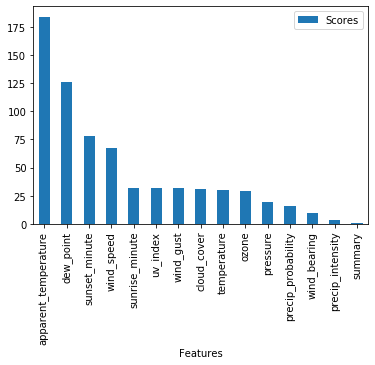

In [78]:
#Feature Importance

fscores = pd.DataFrame({'Features': list(xgb.get_booster().get_fscore().keys()), 'Scores': list(xgb.get_booster().get_fscore().values())})
fscores.sort_values(by='Scores', ascending=False).plot.bar(x='Features')
plt.show()

In [79]:
fscores.sort_values(by='Scores', ascending=False)

,Features,Scores
1,apparent_temperature,184
0,dew_point,126
6,sunset_minute,78
2,wind_speed,67
3,sunrise_minute,32
5,uv_index,32
7,wind_gust,32
4,cloud_cover,31
13,temperature,30
10,ozone,29


In [80]:
# We'll get the prediction to check the performance of our model, and tune the parameters accordingly

y_pred = xgb.predict(X_test)

In [81]:
from sklearn.metrics import r2_score, mean_squared_error

print('R2 Score: ',np.round(r2_score(y_test, y_pred),3))
print('Root Mean Squared Error: ',np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3))

R2 Score:  0.568
Root Mean Squared Error:  410.023


#### We'll use bayesian optimization for hyperparameter tuning. We can also use GridSearach, but it requires larger computational power

In [82]:
#Bayesian Optimization function for xgboost, maximizing r2_score

from bayes_opt import BayesianOptimization

def xgb_evaluate(max_depth, n_estimators, learning_rate):
    params = {'max_depth': int(max_depth),
              'n_estimators': int(n_estimators),
              'learning_rate': learning_rate}
    model = XGBRegressor(**params)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    return r2_score(y_test,pred)

In [83]:
# bounds / parameter list for optimization

bounds = {'max_depth': (3,10),
          'n_estimators': (50,500),
          'learning_rate': (0.01,0.1)}

In [84]:
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=bounds, random_state=1, verbose=True)

In [85]:
optimizer.maximize(n_iter=100, init_points=10, acq='ei')

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
[14:34:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  3        |  0.631    |  0.02676  |  5.419    |  228.5    |
[14:34:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarede

[14:45:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:58] WARNI

[14:58:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:26] WARNI

In [86]:
optimizer.max['params']

{'learning_rate': 0.02263482447357104,
 'max_depth': 4.386710423594152,
 'n_estimators': 410.3350559039915}

In [87]:
params = optimizer.max['params']

In [88]:
# Convert the max_depth and n_estimator values from float to int

params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

In [89]:
xgb = XGBRegressor(**params).fit(X_train,y_train)

[15:04:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [90]:
# Prediction to verify the score is better after tuning the parameters

y_pred = xgb.predict(X_test)

In [91]:
print('R2 Score: ',np.round(r2_score(y_test, y_pred),3))
print('Root Mean Squared Error: ',np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3))

R2 Score:  0.68
Root Mean Squared Error:  352.92


#### According to our requirement, we can fit the model by tuning the parameters to get the desired performance metrics. Here we have used tuning to increase R2 score.

In [92]:
# Let us check the weather_forecast table

weather_forecast.head(3)

,plant_id,datetime_utc,datetime_local,cloud_cover,apparent_temperature,temperature,humidity,dew_point,wind_bearing,wind_speed,...,precip_accumulation,precip_intensity,precip_probability,precip_type,visibility,sunrise,sunset,icon,summary,updated_at
0,1,2019-09-30 18:30:00,2019-10-01 00:00:00,0.35,26.41,26,1,22.01,101,3.08,...,NaN,0.0,0.0,NaN,16.09,2019-10-01 00:51:47,2019-10-01 12:45:42,partly-cloudy-night,Partly Cloudy,2019-10-02 23:32:38
1,1,2019-09-30 19:30:00,2019-10-01 01:00:00,0.43,25.95,25,1,22.06,105,2.94,...,NaN,0.0,0.0,NaN,16.09,2019-10-01 00:51:47,2019-10-01 12:45:42,partly-cloudy-night,Partly Cloudy,2019-10-02 23:32:38
2,1,2019-09-30 20:30:00,2019-10-01 02:00:00,0.48,25.46,25,1,22.06,106,2.82,...,NaN,0.0,0.0,NaN,16.09,2019-10-01 00:51:47,2019-10-01 12:45:42,partly-cloudy-night,Partly Cloudy,2019-10-02 23:32:38


In [93]:
weather_forecast.isna().sum()

plant_id                  0
datetime_utc              0
datetime_local            0
cloud_cover               0
apparent_temperature      0
temperature               0
humidity                  0
dew_point                 0
wind_bearing              0
wind_speed                0
wind_chill              648
wind_gust                 0
heat_index              648
pressure                  0
qpf                     648
uv_index                  0
snow                    648
pop                     648
fctcode                 648
ozone                     0
precip_accumulation     648
precip_intensity          0
precip_probability        0
precip_type             534
visibility                0
sunrise                   0
sunset                    0
icon                      0
summary                   0
updated_at                0
dtype: int64

#### We'll drop the table which have 100% missing values

In [94]:
weather_forecast = weather_forecast.drop(['plant_id','updated_at','datetime_utc','wind_chill','heat_index','qpf','snow','pop',
                                      'fctcode','precip_accumulation'], axis=1)

In [95]:
# As we had done earlier, we'll extract hours and minutes from sunrise and sunset and drop them

weather_forecast['sunrise'] = pd.to_datetime(weather_forecast['sunrise'])
weather_forecast['sunset'] = pd.to_datetime(weather_forecast['sunset'])

In [96]:
weather_forecast['sunrise_hour'] = weather_forecast['sunrise'].dt.hour
weather_forecast['sunrise_minute'] = weather_forecast['sunrise'].dt.minute
weather_forecast['sunset_hour'] = weather_forecast['sunset'].dt.hour
weather_forecast['sunset_minute'] = weather_forecast['sunset'].dt.minute

In [97]:
weather_forecast = weather_forecast.drop(['sunrise','sunset'], axis=1)

In [98]:
# Fill the missing values with "no rain", as we had done earlier

weather_forecast['precip_type'] = weather_forecast['precip_type'].fillna('no rain')

In [99]:
# confirm that there are no missing values

weather_forecast.isna().sum()

datetime_local          0
cloud_cover             0
apparent_temperature    0
temperature             0
humidity                0
dew_point               0
wind_bearing            0
wind_speed              0
wind_gust               0
pressure                0
uv_index                0
ozone                   0
precip_intensity        0
precip_probability      0
precip_type             0
visibility              0
icon                    0
summary                 0
sunrise_hour            0
sunrise_minute          0
sunset_hour             0
sunset_minute           0
dtype: int64

In [100]:
#weather_forecast['power'] = np.nan

#### We'll divide the numerical & categorical columns, and apply scaling and label encoding on them respectively

In [101]:
num_cols = weather_forecast[['cloud_cover', 'apparent_temperature', 'temperature', 'dew_point', 'wind_bearing', 'wind_speed',
                                'wind_gust', 'pressure', 'uv_index', 'ozone', 'precip_intensity', 'precip_probability',
                                'visibility', 'sunrise_hour', 'sunrise_minute', 'sunset_hour', 'sunset_minute']]

In [102]:
scaled2 = std.fit_transform(num_cols)
num_cols_scaled = pd.DataFrame(scaled2, columns=num_cols.columns)
num_cols_scaled.head(3)

,cloud_cover,apparent_temperature,temperature,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,precip_intensity,precip_probability,visibility,sunrise_hour,sunrise_minute,sunset_hour,sunset_minute
0,0.767213,-0.250906,-0.287422,1.998152,-0.371283,1.144739,1.930617,-1.523428,-0.649491,-2.228805,-0.237457,-0.370598,0.0,-0.894427,0.730658,0.0,1.71383
1,1.059958,-0.351058,-0.508096,2.011988,-0.336970,0.959546,1.839240,-1.630780,-0.649491,-2.073821,-0.237457,-0.370598,0.0,-0.894427,0.730658,0.0,1.71383
2,1.242923,-0.457741,-0.508096,2.011988,-0.328392,0.800809,1.708702,-1.804588,-0.649491,-1.887840,-0.237457,-0.370598,0.0,-0.894427,0.730658,0.0,1.71383


In [103]:
cat_cols = weather_forecast[['humidity', 'icon', 'summary', 'precip_type']]
cat_col_names = ['humidity', 'icon', 'summary', 'precip_type']
for i in cat_col_names :
    cat_cols[i] = le.fit_transform(cat_cols[i])

In [104]:
test_features = pd.concat([num_cols_scaled, cat_cols], axis=1)
test_features.head(3)

,cloud_cover,apparent_temperature,temperature,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,...,precip_probability,visibility,sunrise_hour,sunrise_minute,sunset_hour,sunset_minute,humidity,icon,summary,precip_type
0,0.767213,-0.250906,-0.287422,1.998152,-0.371283,1.144739,1.930617,-1.523428,-0.649491,-2.228805,...,-0.370598,0.0,-0.894427,0.730658,0.0,1.71383,1,4,4,0
1,1.059958,-0.351058,-0.508096,2.011988,-0.336970,0.959546,1.839240,-1.630780,-0.649491,-2.073821,...,-0.370598,0.0,-0.894427,0.730658,0.0,1.71383,1,4,4,0
2,1.242923,-0.457741,-0.508096,2.011988,-0.328392,0.800809,1.708702,-1.804588,-0.649491,-1.887840,...,-0.370598,0.0,-0.894427,0.730658,0.0,1.71383,1,4,4,0


In [105]:
test_features.shape

(648, 21)

In [106]:
train_features.shape

(13619, 21)

#### Our model is ready to make the required predictions. We'll use the features of weather_forecast table to predict the power forecast for the same time period

In [107]:
power_pred = xgb.predict(test_features)

In [108]:
# Submit predictions in a dataframe

power_forecast = pd.DataFrame({'datetime_local':weather_forecast.datetime_local, 'power':power_pred})
power_forecast.head(10)

,datetime_local,power
0,2019-10-01 00:00:00,370.656982
1,2019-10-01 01:00:00,229.296127
2,2019-10-01 02:00:00,323.736572
3,2019-10-01 03:00:00,326.434967
4,2019-10-01 04:00:00,326.434967
5,2019-10-01 05:00:00,273.358368
6,2019-10-01 06:00:00,272.847229
7,2019-10-01 07:00:00,411.618896
8,2019-10-01 08:00:00,-85.768829
9,2019-10-01 09:00:00,287.428986


In [109]:
# Save the predictions as a csv file "power_forecast"

power_forecast.to_csv("E:/Work/Amaan/Jobs/reapplicationforthepostofmachinelearningengineer/power_forecast.csv", index=None)

#### ------------------------------------------------------------------------------------END OF NOTEBOOK-------------------------------------------------------------------------------------------------